In [21]:
import subprocess
import sys
import io
import numpy as np
import pandas as pd
import seaborn as sns


#Интервал времени в секундах деления пакетов
DATE_INTERVAL = 30
#Список конечных параметров для сравнения. В коде почечены темиже числами для ориентирования
FEATURES = [
    'client_package_size_mean', #1
    'client_package_size_std', #2
    'server_package_size_mean', #3
    'server_package_size_std', #4
    'client_batch_sizes_mean', #5
    'client_batch_sizes_std', #6
    'server_batch_sizes_mean', #7
    'server_batch_sizes_std', #8
    'client_batch_counts_mean', #9
    'server_batch_counts_mean', #10
    'client_efficiency', #11
    'server_efficiency', #12
    'ratio_sizes', #13
    'ratio_application_size', #14
    'ratio_packages', #15
    'client_package_size_sum', #16
    'client_application_size_sum', #17
    'client_package_count', #18
    'client_batch_counts_sum', #19
    'server_package_size_sum', #20
    'server_application_size_sum', #21
    'server_package_count', #22
    'server_batch_counts_sum', #23
    'transport_protocol', #24
    'ip_protocol_version', #25
]

pcap_file_path = '../id2t_results/21_20200526-122059.pcap' #21
# pcap_file_path = '../id2t_results/dimapac_20200526-082139.pcap' #dima
#pcap_file_path = '../file.pcap'
#Читаем .pcap файл и экспортируем в cvs
pcapToCVSCom = 'tshark -r '+ pcap_file_path + ' -T fields \
-e frame.time_epoch -e ip.src -e ip.dst -e ip.proto -e frame.len -e ip.version \
-e tcp.srcport -e tcp.dstport -e udp.srcport -e udp.dstport -e ip.hdr_len -e tcp.hdr_len \
-E separator=, -E quote=d -E header=y -E occurrence=f'
proc = subprocess.Popen(pcapToCVSCom.split() + ['-Y', '(ip.proto == 17 || ip.proto == 6) && !icmp'],
                        stdin=subprocess.PIPE, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
output, error = proc.communicate()
data = ''
if error:
    sys.exit(error.decode("utf-8")) #или "ISO-8859-1"
else:
    data = output.decode("utf-8")
    f = open("./sel.csv", "w")
    f.write(output.decode("utf-8"))
    f.close()
traffic = pd.read_csv(io.StringIO(data), sep=',')

In [6]:
befora = traffic

In [22]:
after = traffic

In [17]:
print(befora.shape)
print(after.shape)

(243895, 12)
(273329, 12)


In [28]:
befora['frame.time_epoch'] = pd.to_datetime(befora['frame.time_epoch'], unit='s')
after['frame.time_epoch'] = pd.to_datetime(after['frame.time_epoch'], unit='s')

In [13]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(15, 6), dpi=80, facecolor='w', edgecolor='k')

<Figure size 1200x480 with 0 Axes>

<Figure size 1200x480 with 0 Axes>

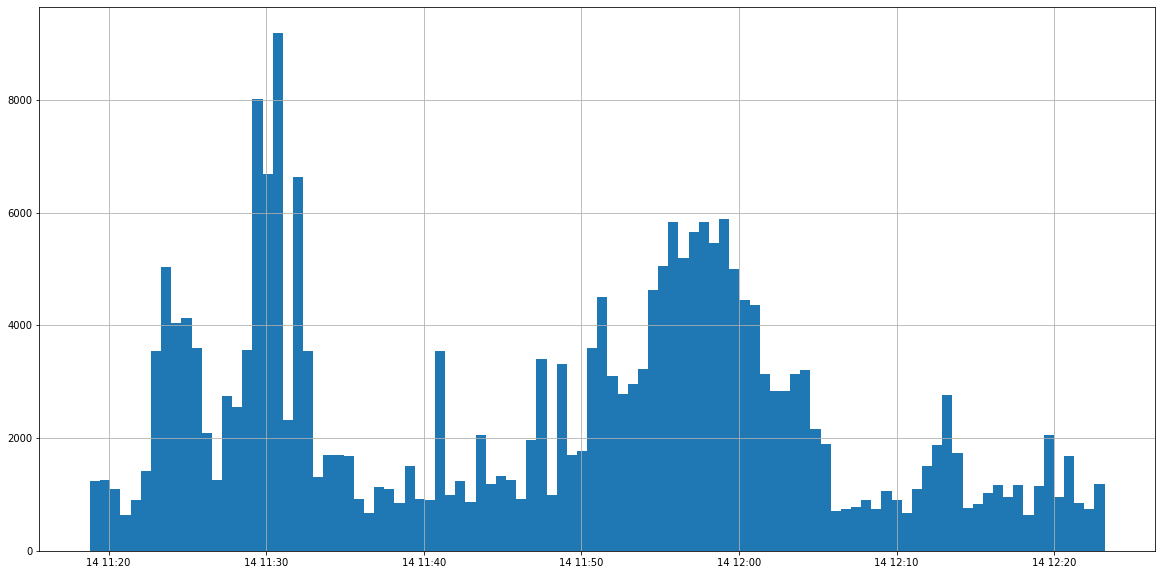

In [20]:
befora['frame.time_epoch'].iloc[:].hist(bins=100, figsize=(20,10))

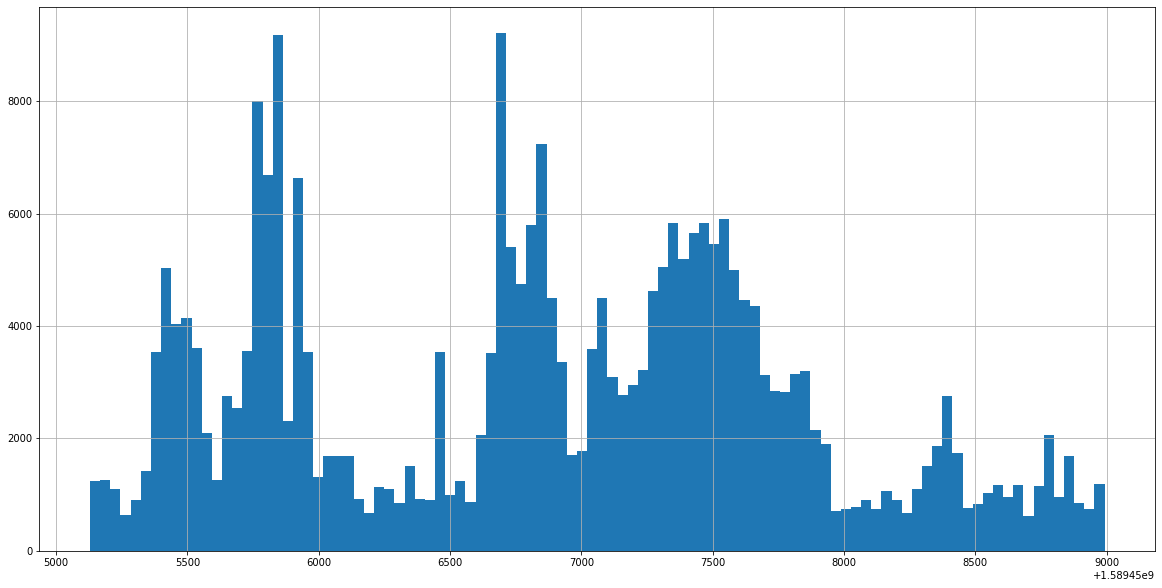

In [19]:
after['frame.time_epoch'].iloc[:].hist(bins=100, figsize=(20,10))

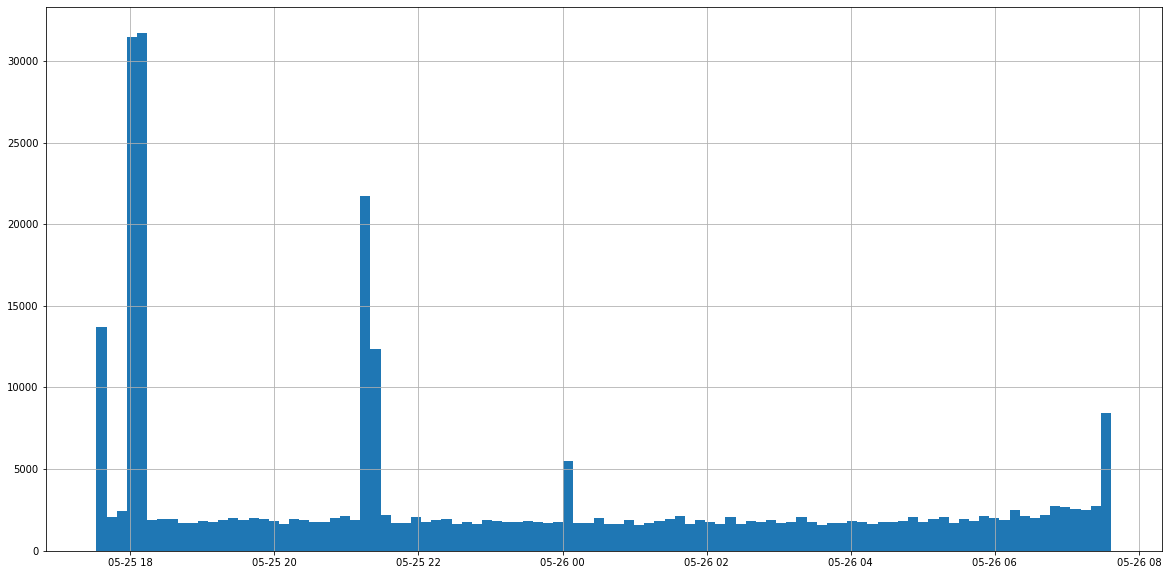

In [29]:
after['frame.time_epoch'].iloc[:].hist(bins=100, figsize=(20,10))

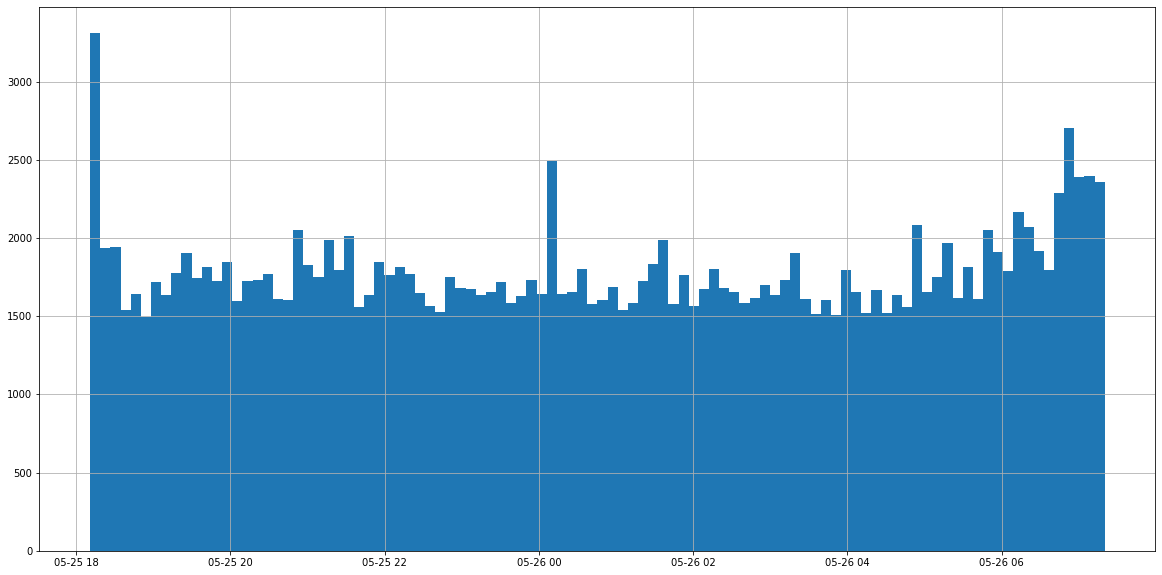

In [143]:
befora['frame.time_epoch'].iloc[79000:159000].append(befora['frame.time_epoch'].iloc[161700:260000]).hist(bins=100, figsize=(20,10))

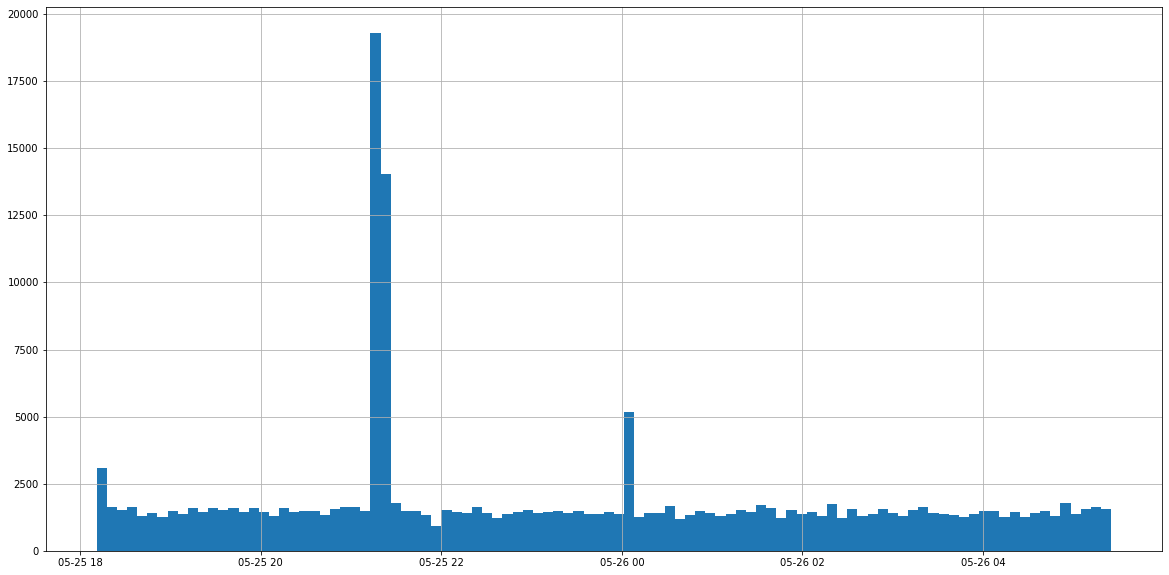

In [146]:
injected['frame.time_epoch'].iloc[:].hist(bins=100, figsize=(20,10))

In [16]:
# Чтение csv файлы. В данной случае читается из созданного потока, для чтения файла использовать:
# traffic = pd.read_csv('/Users/theeska/Downloads/traffic.csv', encoding = "ISO-8859-1", low_memory=False)


#Получение ip клиента
clientIP = pd.concat([traffic['ip.src'], traffic['ip.dst']]).value_counts().idxmax()

#Преобразование портов в один стобец
traffic['srcport'] = traffic['udp.srcport'].combine(traffic['tcp.srcport'], lambda x,y: x if np.isnan(y) else y).astype(int)
traffic['dstport'] = traffic['tcp.dstport'].combine(traffic['udp.dstport'], lambda x,y: x if np.isnan(y) else y).astype(int)
traffic = traffic.drop(['tcp.srcport', 'udp.srcport', 'tcp.dstport', 'udp.dstport'], axis=1)

#Получение конечных точек (<IP>:<port>) и указание направления трафика для пакета
traffic['isFromClient'] = traffic['ip.src'] == clientIP
traffic['src'] = traffic['ip.src'] + ":"  + traffic['srcport'].apply(str)
traffic['dest'] = traffic['ip.dst'] + ":" + traffic['dstport'].apply(str)
traffic = traffic.drop(['srcport', 'dstport', 'ip.src', 'ip.dst'], axis=1)

#Подстановка длины хэддера для UDP
traffic = traffic.rename(columns={"tcp.hdr_len": "transport_header"})
traffic.loc[traffic['ip.proto'] == 17, 'transport_header'] = int(8)

#рассчет прикладной нагрузки пакета
traffic['application_size'] = traffic['frame.len'] - 14 - traffic['ip.hdr_len'] - traffic['transport_header']

#Преобразование UNIX-времени к pandas.datetime64 группировка с интервалом DATE_INTERVAL секунд
traffic['frame.time_epoch'] = pd.to_datetime(traffic['frame.time_epoch'], unit='s')

In [29]:
intervalledPackeges = list()
intarval_offser_count = 4
base_delta = DATE_INTERVAL / 4
for i in range(intarval_offser_count):
    grouped = traffic.groupby(pd.Grouper(freq=str(DATE_INTERVAL) + 'S', key='frame.time_epoch', base=base_delta*i))
    for key, _ in grouped:
        print(key)
        intervalledPackeges.append((key, grouped.get_group(key)))
    print('end\n')


2020-04-27 21:08:30
2020-04-27 21:09:00
2020-04-27 21:09:30
2020-04-27 21:10:00
end

2020-04-27 21:08:07.500000
2020-04-27 21:08:37.500000
2020-04-27 21:09:07.500000
2020-04-27 21:09:37.500000
2020-04-27 21:10:07.500000
end

2020-04-27 21:08:15
2020-04-27 21:08:45
2020-04-27 21:09:15
2020-04-27 21:09:45
end

2020-04-27 21:08:22.500000
2020-04-27 21:08:52.500000
2020-04-27 21:09:22.500000
2020-04-27 21:09:52.500000
end



In [13]:
traffic.head()

,frame.time_epoch,ip.proto,frame.len,ip.version,ip.hdr_len,transport_header,isFromClient,src,dest,application_size
0,2020-04-27 21:08:35.658354998,6,203,4,20,32.0,True,192.168.1.53:64521,173.194.221.132:443,137.0
1,2020-04-27 21:08:35.661669016,17,79,4,20,8.0,True,192.168.1.53:58772,192.168.1.1:53,37.0
2,2020-04-27 21:08:35.679302931,17,95,4,20,8.0,False,192.168.1.1:53,192.168.1.53:58772,53.0
3,2020-04-27 21:08:35.680814028,6,78,4,20,44.0,True,192.168.1.53:64536,64.233.165.84:443,0.0
4,2020-04-27 21:08:35.690493107,6,66,4,20,32.0,False,173.194.221.132:443,192.168.1.53:64521,0.0


In [28]:
for i in range(4):
    print(i)

0
1
2
3


In [1]:
from sklearn.svm import OneClassSVM
from sklearn.model_selection import GridSearchCV
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.metrics import make_scorer, f1_score
from sklearn import model_selection
from sklearn.datasets import make_classification

In [2]:
df = pd.read_pickle("./dimapac.pkl")
df_deopped = df.drop(['route', 'timestamp'], axis=1)

In [3]:
train_length = int(df_deopped.shape[0] * 0.8)
train_df = df_deopped.iloc[:train_length]
test_df = df_deopped.iloc[train_length:]

In [4]:
train_df.shape

(3749, 25)

In [5]:
clf = IsolationForest(random_state=47)

param_grid = {'n_estimators': list(range(50, 100, 5)), 
              'max_samples': list(range(40, 80, 5)), 
              'contamination': [0.1, 0.2, 0.3, 0.4, 0.5], 
              'max_features': [5,10,15], 
              'bootstrap': [True, False], 
              'n_jobs': [5, 10, 20, 30]}
grid_dt_estimator = model_selection.GridSearchCV(clf, 
                                                 param_grid,
                                                 scoring="f1", 
                                                 refit=True,
                                                 cv=10, 
                                                 return_train_score=True)
grid_dt_estimator.fit(train_df, np.full(train_length, 1))

KeyboardInterrupt: 

In [25]:
grid_dt_estimator.best_estimator_

IsolationForest(bootstrap=True, contamination=0.1, max_features=10,
                max_samples=40, n_estimators=80, n_jobs=5, random_state=47)

In [ ]:
import matplotlib
from matplotlib import pyplot as 
from matplotlib.pyplot import figure

In [ ]:
def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()

In [ ]:
figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')
f_importances(svc_clf.best_estimator_.coef_[0], FEATURES)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


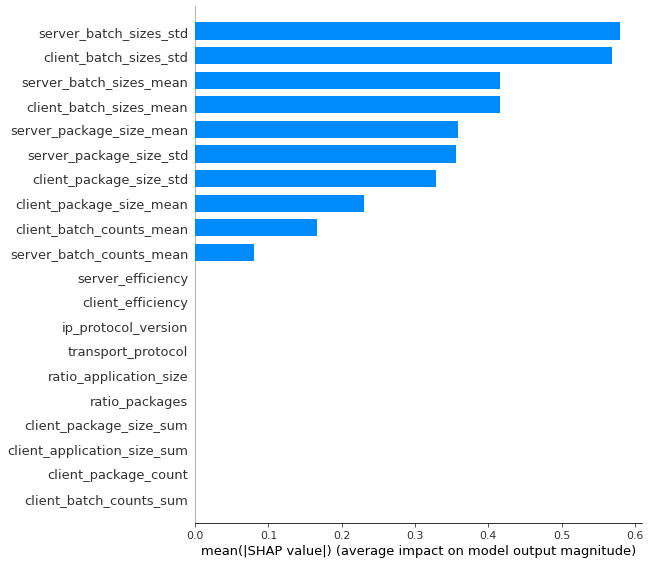

In [15]:
import shap

shap_values = shap.TreeExplainer(clf).shap_values(X_explain)
shap.summary_plot(shap_values, test_df, plot_type="bar")

In [14]:
shap_values

array([[-0.21008586, -0.35899291, -0.32067572, ...,  0.        ,
         0.        ,  0.        ],
       [-0.24292546, -0.40601921, -0.42880968, ...,  0.        ,
         0.        ,  0.        ],
       [-0.20724173, -0.32713599, -0.39135024, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.19767628, -0.3565346 , -0.35152356, ...,  0.        ,
         0.        ,  0.        ],
       [-0.20377988, -0.30043458, -0.24676125, ...,  0.        ,
         0.        ,  0.        ],
       [-0.4039657 , -0.56235914, -0.21894901, ...,  0.        ,
         0.        ,  0.        ]])

In [6]:
clf = IsolationForest(bootstrap=True, contamination=0.1, max_features=10,
                max_samples=40, n_estimators=80, n_jobs=5, random_state=47)
clf.fit(train_df)

IsolationForest(bootstrap=True, contamination=0.1, max_features=10,
                max_samples=40, n_estimators=80, n_jobs=5, random_state=47)

In [34]:
y = clf.predict(test_df)

In [38]:
print("Класс '-1' - нехарактерный траффик, '1' - характерный траффик")

print("\n---Информация о пакетах взятых из открытых источников и никак не связанных с начаьной выборкой ")
y = clf.predict(extern_traffic)
uniqueValues, occurCount = np.unique(y, return_counts=True)
print("Полученные классы : " , uniqueValues[::-1])
print("Количество обхектов в каждом классе соотвественно : ", occurCount)

print("\n---Информация о пакетах которые были отложены из начальный выборки для теста ")
y = clf.predict(test_df)
uniqueValues, occurCount = np.unique(y, return_counts=True)
print("Полученные классы : " , uniqueValues[::-1])
print("Количество обхектов в каждом классе соотвественно : ", occurCount)

Класс '-1' - нехарактерный траффик, '1' - характерный траффик

---Информация о пакетах взятых из открытых источников и никак не связанных с начаьной выборкой 
Полученные классы :  [ 1 -1]
Количество обхектов в каждом классе соотвественно :  [  15 1160]

---Информация о пакетах которые были отложены из начальный выборки для теста 
Полученные классы :  [ 1 -1]
Количество обхектов в каждом классе соотвественно :  [ 85 853]


In [36]:
extern_traffic = pd.read_pickle("../traffic_analyzer/file.pkl")
extern_traffic = extern_traffic.drop(['route', 'timestamp'], axis=1)

In [44]:
from sklearn import metrics
print(metrics.classification_report(np.full(938, 1), y))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           1       1.00      0.91      0.95       938

    accuracy                           0.91       938
   macro avg       0.50      0.45      0.48       938
weighted avg       1.00      0.91      0.95       938



/home/theeska/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [43]:
len(y)

938